In [20]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import Xception
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

In [21]:
train_dir = r'D:\Programowanie\Workplace\Code\Java\brain-tumor-detector\dataset\Training'
test_dir = r'D:\Programowanie\Workplace\Code\Java\brain-tumor-detector\dataset\Testing'

In [22]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [23]:
X_train = []
Y_train = []

image_size = 224

for label in labels:
    path = os.path.join(train_dir, label)
    class_num = labels.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)
        
for label in labels:
    path = os.path.join(test_dir, label)
    class_num = label.index(label)
    for img in os.listdir(path):
        img_array = plt.imread(os.path.join(path, img))
        img_resized = resize(img_array, (image_size, image_size, 3))
        X_train.append(img_resized)
        Y_train.append(class_num)
        
X_train = np.array(X_train)
Y_train = np.array(Y_train)

In [24]:
X_train.shape

(7023, 224, 224, 3)

In [25]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [26]:
X_train.shape

(7023, 224, 224, 3)

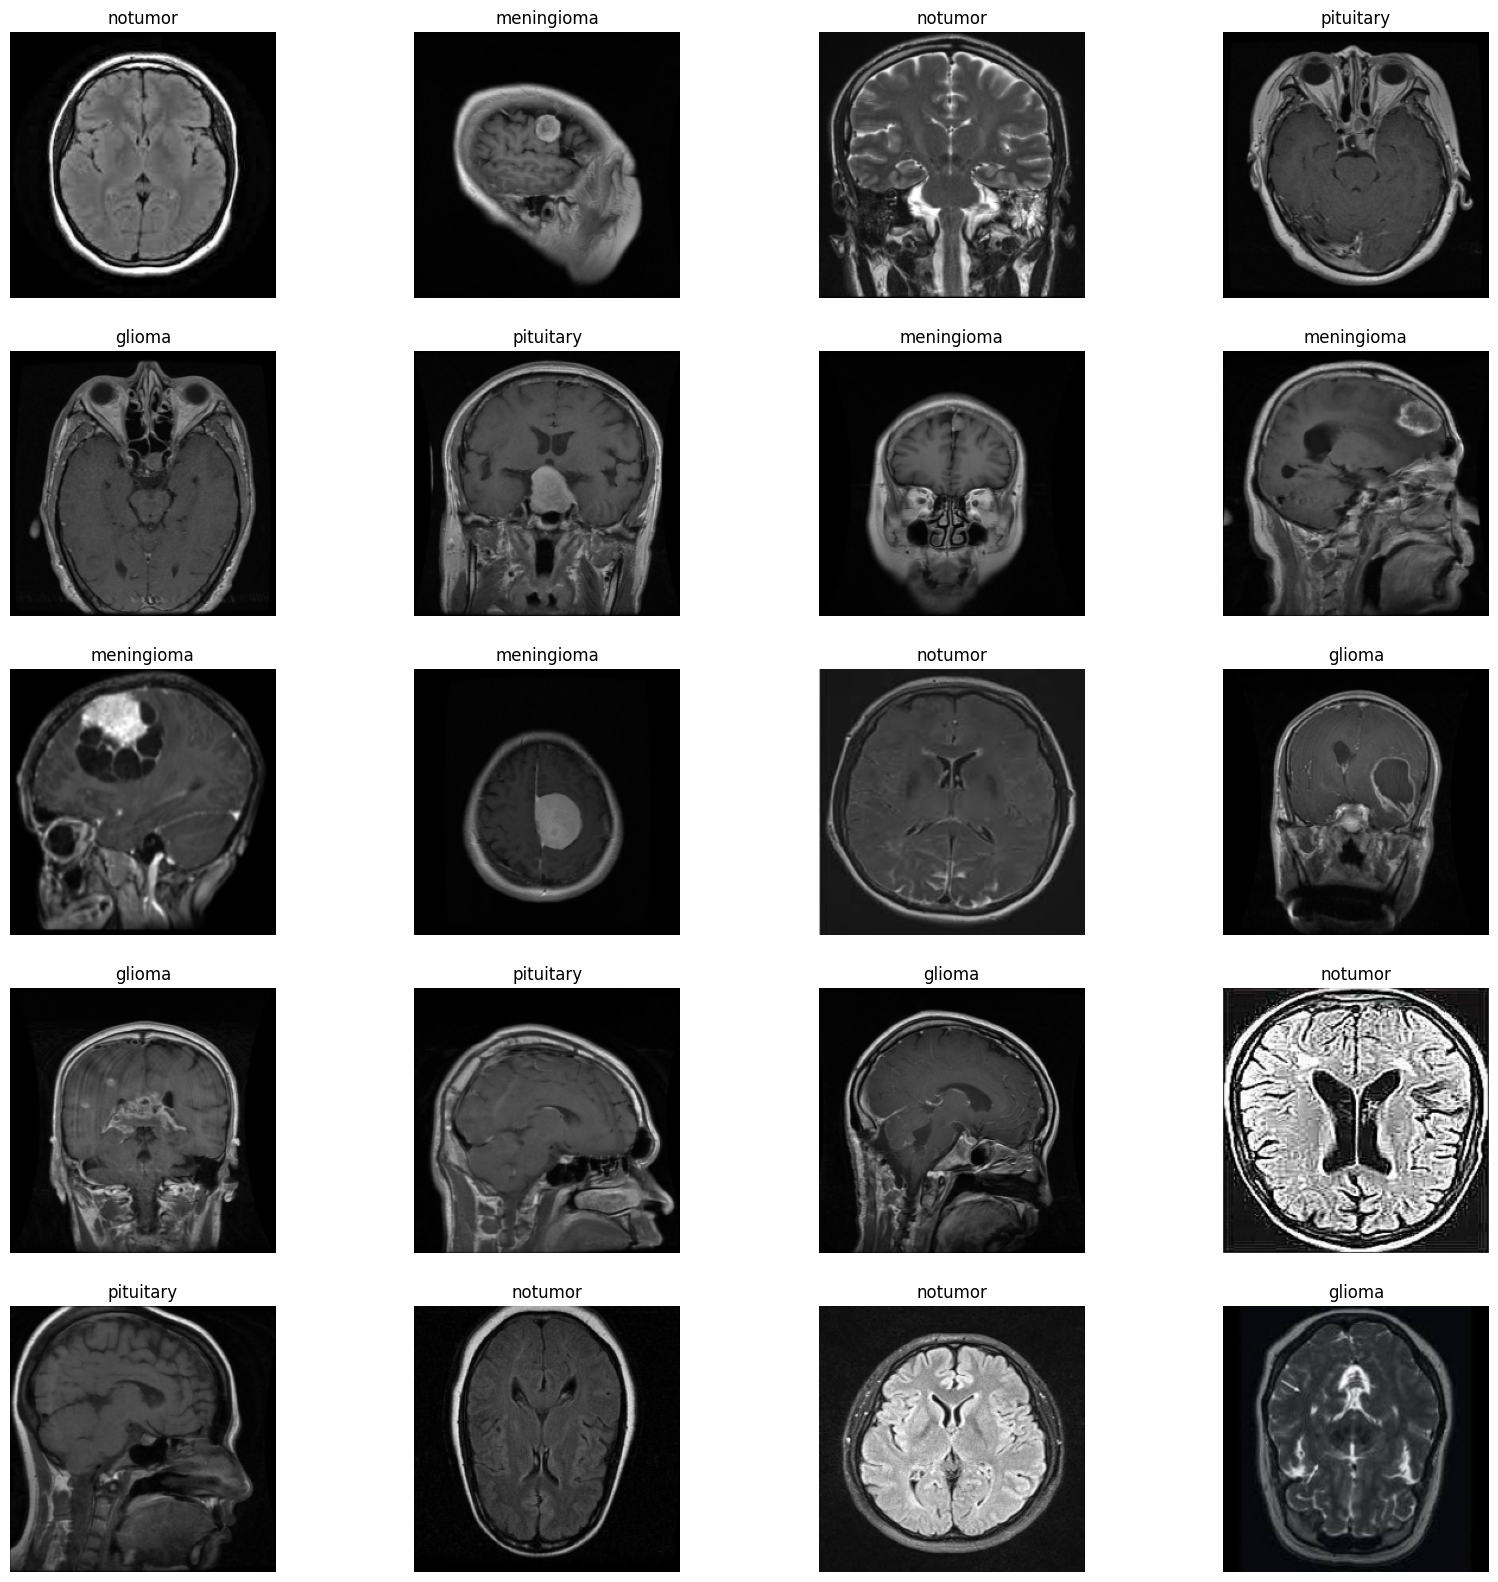

In [27]:
plt.figure(figsize=(20, 20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_train[i])
    plt.title(labels[Y_train[i]])
    plt.axis('off')
plt.show()

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [29]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

datagen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

datagen.fit(X_train)

y_train_new = to_categorical(Y_train, num_classes=4)
y_valid_new = to_categorical(Y_valid, num_classes=4)
y_test_new = to_categorical(Y_test, num_classes=4)

In [32]:
from tensorflow.keras.applications import Xception
img_shape = (224, 224, 3)
base_model =Xception(input_shape=img_shape, include_top=False, weights='imagenet',
                                            pooling= 'max')

model = Sequential([
    base_model,
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])
model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('Bmodel.keras', monitor='val_loss', save_best_only=True)


model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [33]:
history = model.fit(datagen.flow(X_train, y_train_new, batch_size=32),
                    epochs=50,validation_data=(X_valid, y_valid_new),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/50


d:\Programowanie\Programy\Python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 11/158 ━━━━━━━━━━━━━━━━━━━━ 6:25 3s/step - accuracy: 0.2545 - loss: 1.9540

KeyboardInterrupt: 